In [131]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from conf_mat import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
import os
import cv2
from face_detect_utils import label_map_util
import tensorflow as tf
import time
from imgaug import augmenters as iaa
import imgaug as ia


%matplotlib inline

# Reading data from facial expression recognition challenge kaggle

In [2]:
df = pd.read_csv("/home/atul/ML/Face_Emmotion/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Data desription and preparation

In [3]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [4]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [5]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [6]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [7]:
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])

In [8]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [9]:
y_test

array([0, 1, 4, ..., 4, 4, 4])

In [10]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

# Visualizing training images

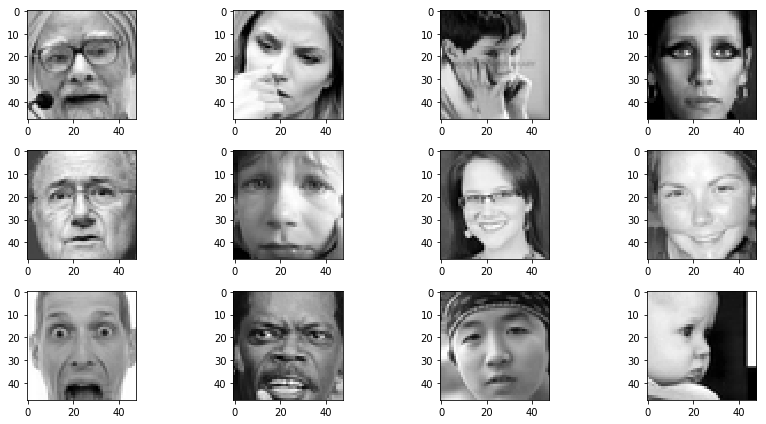

In [11]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

# Defining model architecture 

In [139]:
class BatchGenerator:
    '''
    A generator to generate batches of samples and corresponding labels indefinitely.

    The labels are read from a CSV file.

    Shuffles the dataset consistently after each complete pass.

    Can perform image transformations for data conversion and data augmentation,
    for details please refer to the documentation of the `generate()` method.
    '''

    def __init__(self,
                 X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train

    def generate(self,batch_size=32,augment_multiplier=0,image_size=160,return_grayscale=False):
        current = 0
        self.shape = self.X_train.shape
        while True:
            if(current>self.shape[0]):
                current=0
                continue
                
            batch_x = self.add_channel(self.X_train[current:current+batch_size])
            batch_y = self.y_train[current:current+batch_size]
            if(augment_multiplier!=0):
                original_dtype = batch_x.dtype
                batch_x = batch_x.astype("uint8")
                batch_x,batch_y = self.augment_data(batch_x,batch_y,augment_multiplier)
                batch_x = batch_x.astype(original_dtype)
            batch_x = self.resize_image(batch_x,image_size=image_size)
            if(return_grayscale):
                batch_x = np.expand_dims(batch_x[:,:,:,0],-1)
            current = current+batch_size
            #print(current)
            yield batch_x,batch_y
    def add_channel(self,data):
        if(self.shape[3]==1):
            temp = np.tile(data,(1,1,1,3))
        else:
            temp = data
        return temp
    def resize_image(self,data,image_size):
        #temp = tf.image.resize_images(data, (image_size, image_size)).eval(session=tf.Session())
        temp = []
        for i in range(data.shape[0]):
            temp.append(cv2.resize(data[i],(image_size,image_size)))
        return np.array(temp)
        
    #Function to create augmentation, multiplier controls number of augmentation per image
    def augment_data(self,train,label,multiplier=0):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.05)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.ContrastNormalization((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-10, 10),
            shear=(-8, 8)
        )
    ], random_order=True)
        image_aug=[]
        image_aug=train
        label_mult =label 
        if(multiplier>=1):
           for i in range(multiplier):
               image_aug=np.vstack([image_aug,seq.augment_images(train)])
               label_mult=np.vstack([label_mult,label])
        return image_aug,label_mult 
        

In [140]:
train_generator = BatchGenerator(x_train,y_train).generate(batch_size=5,augment_multiplier=4,image_size=48,
                                                           return_grayscale=True)
val_generator = BatchGenerator(x_test,y_test).generate(batch_size=5,augment_multiplier=4,image_size=48,
                                                      return_grayscale=True)

In [144]:
next(train_generator)

23.3 ms ± 363 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


5
(25, 48, 48, 1)


Text(0.5, 0, 'augmented')

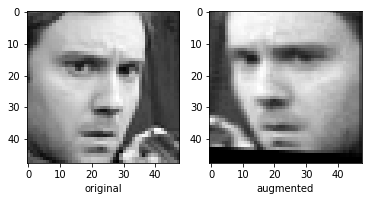

In [14]:
(augmented_image,label) = next(train_generator)
print(augmented_image.shape)
fig,ax = plt.subplots(1,2)
ax[0].imshow(augmented_image[0,:,:,0],cmap="gray")
ax[0].set_xlabel("original")
ax[1].imshow(augmented_image[5,:,:,0],cmap="gray")
ax[1].set_xlabel("augmented")

In [15]:
model = Sequential()

model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.load_weights("face_model.h5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activat

# Training and checkpointing best model

In [16]:
# save best weights
#checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# num epochs
#epochs = 10

# run model
# hist = model.fit(x_train, y_train, epochs=epochs,
#                  shuffle=True,
#                  batch_size=128, validation_data=(x_test, y_test),
#                  callbacks=[checkpointer], verbose=2)


In [1]:
checkpointer = ModelCheckpoint(
        filepath='augmented_face_model.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        monitor='val_loss',save_best_only=True,
        verbose=1)

batch_size = 16
steps_per_epoch = np.ceil(x_train.shape[0]/batch_size)
validation_steps = np.ceil(x_test.shape[0]/batch_size)
epochs = 2

hist = model.fit_generator(train_generator, epochs=epochs,steps_per_epoch=steps_per_epoch,
                 shuffle=True,
                 validation_data=val_generator,
                 validation_steps = validation_steps,
                 callbacks=[checkpointer], verbose=1)


# Plotting loss curve for training and validation set

In [17]:
# plt.figure(figsize=(14,3))
# plt.subplot(1, 2, 1)
# plt.suptitle('Optimizer : Adam', fontsize=10)
# plt.ylabel('Loss', fontsize=16)
# plt.plot(hist.history['loss'], color='b', label='Training Loss')
# plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
# plt.legend(loc='upper right')

# plt.subplot(1, 2, 2)
# plt.ylabel('Accuracy', fontsize=16)
# plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
# plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.show()

# Preparing test data for evaluating model

In [18]:
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [19]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [20]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

# Model Evaluation

In [21]:
probs = model.predict(x_test_private)
preds = probs.argmax(axis=1)
y_label = np.argmax(y_test_private,axis=1)

In [40]:
pd.Series(preds).map(str).map(emmotion_map).value_counts()

Happy       915
Neutral     728
Sad         702
Angry       483
Surprise    434
Fear        297
Disgust      30
dtype: int64

In [22]:
Accuracy = np.mean(preds==y_label)
Accuracy

0.6517135692393424

In [23]:
emmotion_map = {"0":"Angry", "1":"Disgust", "2":"Fear", "3":"Happy", "4":"Sad", "5":"Surprise", "6":"Neutral"}

In [24]:
cm = confusion_matrix(pd.Series(y_label).map(str).map(emmotion_map),pd.Series(preds).map(str).map(emmotion_map))

Confusion matrix, without normalization


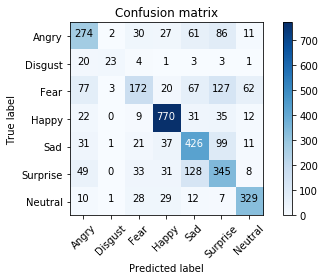

In [28]:
classes=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
plot_confusion_matrix(cm,classes=classes)

In [1]:
172/(77+3+172+20+67+127+62)

0.32575757575757575

# Plotting ROC curves with auc values

In [53]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_private[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_private.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

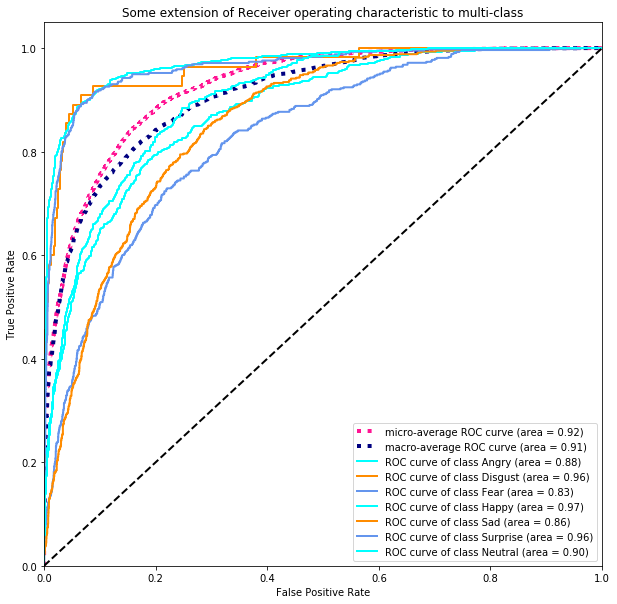

In [54]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Video Emotion Detection Demo

In [29]:
W,H = 224,224

In [30]:
def FrameCapture(path):
    """
    Read video files and extract frames at some equal intervals
    """
    vidObj = cv2.VideoCapture(path) 
    count = 0
    success = 1
    Image = []
    while success: 
        success, image = vidObj.read()
        if(not success):
            break
        if(count%10==0):
            image = cv2.resize(image, (W,H))
            Image.append(image)
        count += 1
    return np.array(Image)


In [31]:
def detect_face_boxes(video_data):
    """
    Takes as input a batch of images and returns bounding boxes, classes, scores for each of them
    """
    PATH_TO_CKPT = './face_detect_model/frozen_inference_graph_face.pb'
    PATH_TO_LABELS = './face_detect_protos/face_label_map.pbtxt'
    NUM_CLASSES = 2
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    with detection_graph.as_default():
      config = tf.ConfigProto()
      config.gpu_options.allow_growth = True
      with tf.Session(graph=detection_graph, config=config) as sess:
          image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
          boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
          scores = detection_graph.get_tensor_by_name('detection_scores:0')
          classes = detection_graph.get_tensor_by_name('detection_classes:0')
          num_detections = detection_graph.get_tensor_by_name('num_detections:0')
          start_time = time.time()
          (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: video_data})
          print("time taken in only bbox prediction",time.time()-start_time)  
        #ymin,xmin,ymax,xmax
    return boxes, scores, classes, num_detections

In [32]:
def plot(video_data,boxes,predictions = None,gray_scale=True):
    """
    plot images with their predicted label for evaluation
    """
    fig,ax = plt.subplots(2,5,figsize=(15,10))
    for i in range(2):
        for j in range(5):
            fig_num = i*5+j
            temp = video_data[fig_num][int(W*boxes[fig_num][0][0]):int(W*boxes[fig_num][0][2]),int(H*boxes[fig_num][0][1]):int(H*boxes[fig_num][0][3]),:]
            if(gray_scale):
               temp = tf.image.rgb_to_grayscale(cv2.resize(temp,(48,48))).eval(session=tf.Session())
               ax[i,j].imshow(temp[:,:,0],cmap="gray")
            else:
               ax[i,j].imshow(temp)
            if(predictions is None):
                ax[i,j].set_xlabel("xyz")
            else:
                ax[i,j].set_xlabel(predictions[fig_num])
            

In [33]:
def preprocess_predict(video_data,boxes):
    """
    Preprocess videos by cropping, resizing, color to grayscale and predicting
    """
    cropped_resized_grayscaled_video = []
    for i in range(video_data.shape[0]):
        temp = video_data[i][int(W*boxes[i][0][0]):int(W*boxes[i][0][2]),int(H*boxes[i][0][1]):int(H*boxes[i][0][3]),:]
        temp = cv2.resize(temp,(48,48))
        cropped_resized_grayscaled_video.append(temp)
    cropped_resized_grayscaled_video = np.array(cropped_resized_grayscaled_video)
    cropped_resized_grayscaled_video = tf.image.rgb_to_grayscale(cropped_resized_grayscaled_video).eval(session=tf.Session())
    predictions = model.predict(cropped_resized_grayscaled_video)
    return predictions

In [34]:
def give_emmotions(video_clip_path):
    """
    Input video file return prediction probabilities for 7 emmotion classes
    """
    start_time = time.time()
    video_data = FrameCapture(video_clip_path)
    print("reading data time taken",time.time()-start_time)
    video_data = video_data[:,:,:,::-1]
    _,W,H,_ = video_data.shape
    boxes, scores, classes, num_detections = detect_face_boxes(video_data)    
    print("time taken till tensorflow predictions",time.time()-start_time)
    predictions = preprocess_predict(video_data,boxes)
    prediction_class = pd.Series(predictions.argmax(axis=1)).map(str).map(emmotion_map)
    plot(video_data,boxes,prediction_class,gray_scale=False)
    print("time taken till preprocessing and prediction",time.time()-start_time)
    return predictions
    

# Get a set of video paths with particular emotion to test the demo below

In [41]:
use_it_to_filter = {"01":"Neutral","02":"Calm","03":"Happy","04":"Sad","05":"Angry",
                "06":"Fearful","07":"Disgust","08":"Surprised"}
def get_video_path_list(emotion):
    """
    Utility function to help you get a set videos with particular emotion
    """
    sub_dir = "/home/atul/Downloads/Actor_01"
    all_data_path = []
    all_data_labels = []
    all_data_path.extend([sub_dir+"/"+file for file in os.listdir(sub_dir)])
    all_data_labels.extend([use_it_to_filter[file.split("-")[2]] for file in os.listdir(sub_dir)])
    index_emotion = np.where(np.array(all_data_labels)==emotion)
    return np.array(all_data_path)[index_emotion]
#You can choose emmotion name by copying from dictionary values defined above
get_video_path_list("Fearful")

array(['/home/atul/Downloads/Actor_01/01-01-06-02-02-02-01.mp4',
       '/home/atul/Downloads/Actor_01/01-01-06-02-02-01-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-02-01-01-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-02-02-02-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-01-02-01-01.mp4',
       '/home/atul/Downloads/Actor_01/01-01-06-01-01-02-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-01-02-02-01.mp4',
       '/home/atul/Downloads/Actor_01/01-01-06-01-02-02-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-01-01-01-01.mp4',
       '/home/atul/Downloads/Actor_01/01-01-06-01-02-01-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-02-01-02-01.mp4',
       '/home/atul/Downloads/Actor_01/01-01-06-02-01-02-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-02-02-01-01.mp4',
       '/home/atul/Downloads/Actor_01/02-01-06-01-01-02-01.mp4',
       '/home/atul/Downloads/Actor_01/01-01-06-02-01-01-01.mp4',
       '/home/atul/Downlo

# Test the model by just inputing you video file path

reading data time taken 0.46121788024902344
time taken in only bbox prediction 2.3411357402801514
time taken till tensorflow predictions 3.415560483932495
time taken till preprocessing and prediction 3.6383056640625


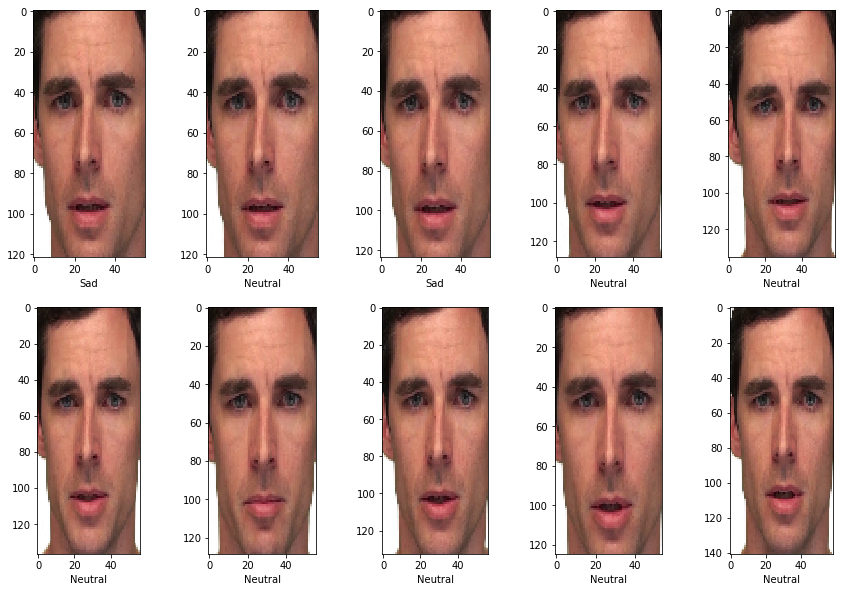

In [42]:
path = '/home/atul/Downloads/Actor_01/02-01-06-01-02-02-01.mp4'
predictions = give_emmotions(path)